Prototype methods classify objects by finding their proximity to a *prototype* in the feature space. These methods are flexible, and can be locally interpretable by looking at nearby examples.

We are going to look at examples of prototype methods on [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), a set of 28x28 pixel black and white images of different items of clothing.
You could use any kind of features but these images are so simple that we can use the pixels themselves as features.

This notebook trains a classifier that gets about 85% accuracy on this dataset using K nearest neighbours, but on the way explores examining data, average prototypes, predicting accuracy with training data size, and approximate nearest neighbours methods.

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# Load in the data

The data is stored as CSVs with a label, then each of the 28x28=784 pixels as columns.

In [2]:
df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
df_test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [3]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The test set has the same format

In [4]:
df_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Data format

We can read out the label and image of any pixel

2


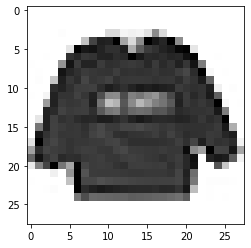

In [5]:
idx = 0

label = df.iloc[idx, 0]
image = df.iloc[idx, 1:].to_numpy().reshape(28, 28)
print(label)
ax = plt.imshow(image, cmap="Greys")

Each image is a series of digits from 0 to 255.
Here's the top left corner.

In [6]:
data = image[:12, :12]
data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   4,   0,   0,   0,   0,   0,  62,  61],
       [  0,   0,   0,   0,   0,   0,   0,  88, 201, 228, 225, 255],
       [  0,   0,   0,   0,   0,  47, 252, 234, 238, 224, 215, 215],
       [  0,   0,   1,   0,   0, 214, 222, 210, 213, 224, 225, 217],
       [  1,   0,   0,   0, 128, 237, 207, 224, 224, 207, 216, 214],
       [  0,   2,   0,   0, 237, 222, 215, 207, 210, 212, 213, 206],
       [  0,   4,   0,  85, 228, 210, 218, 200, 211, 208, 203, 215],
       [  0,   0,   0, 217, 224, 215, 206, 205, 204, 217, 230, 222],
       [  1,   0,  21, 225, 212, 212, 203, 211, 225, 193, 139, 136]])

Each number maps the corresponding pixel to a color; the larger the number the more black to use.

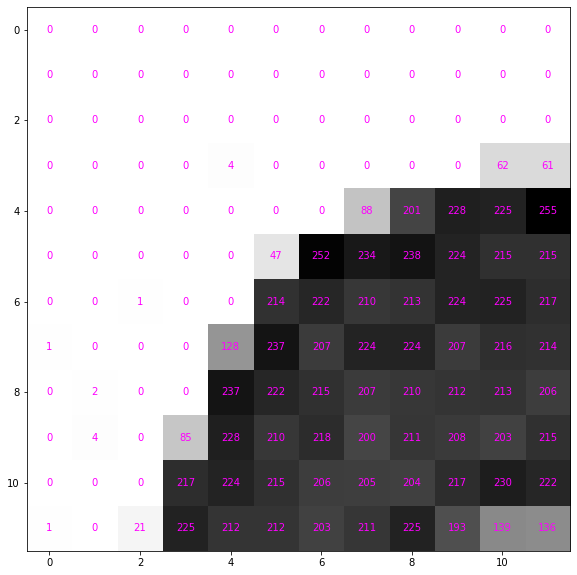

In [7]:
def show_data(data, figsize=(10,10), ax=None, formatter='{:}'.format):
    assert data.ndim == 2
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(data, cmap="Greys")

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j, i, formatter(data[i, j].item()), ha="center", va="center", color="magenta")
    return ax

ax = show_data(data)

It's more convenient to use floating point numbers.
Renormalise between 0 and 1 and convert it to a pytorch tensor.

In [8]:
image_tensor = image / 255.

data_tensor = image_tensor[:12, :12]
data_tensor

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01568627,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.24313725, 0.23921569],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.34509804, 0.78823529, 0.89411765,
        0.88235294, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.18431373, 0.98823529, 0.91764706, 0.93333333, 0.87843137,
        0.84313725,

It still looks the same but the numbers are scaled down

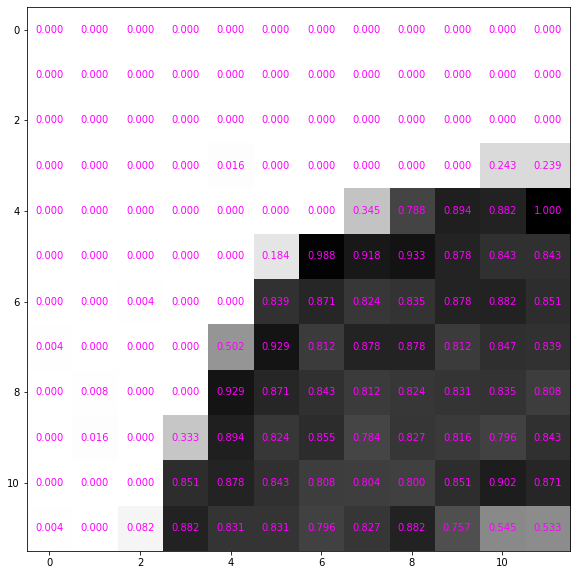

In [9]:
ax = show_data(data_tensor, formatter='{:0.3f}'.format)

How does imshow know how dark to make the cells?

By default it makex the smallest value whitest and the largest black.
From the [documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html) this can be controlled with vmin and vmax
    
> vmin, vmax: float, optional

>    When using scalar data and no explicit norm, vmin and vmax define the data range that the colormap covers. By default, the colormap covers the complete value range of the supplied data. It is an error to use vmin/vmax when norm is given. When using RGB(A) data, parameters vmin/vmax are ignored.


So if we double vmax the image appears fainter.

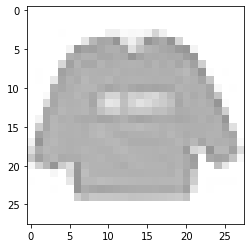

In [10]:
plt.imshow(image_tensor, cmap='Greys', vmin=0., vmax=2.)

## Convert data

Let's put all the data into a large normalised array

In [11]:
images = df.filter(regex='^pixel[0-9]+$', axis=1).to_numpy().reshape((-1, 28, 28)) / 255.

images_test = df_test.filter(regex='^pixel[0-9]+$', axis=1).to_numpy().reshape((-1, 28, 28)) / 255.

In [12]:
images.shape

(60000, 28, 28)

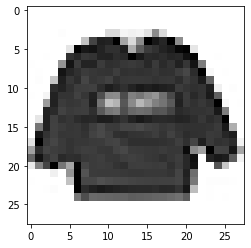

In [13]:
_ = plt.imshow(images[0], cmap='Greys')

So we understand the data let's use human readable labels.
This helps us understand how to classify the data and understand if we've made any mistakes.
These are copied from the documentation for Fashion MNIST.

In [14]:
labels_txt = """
Label	Description
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
""".strip()

In [15]:
from io import StringIO

df_labels = pd.read_csv(StringIO(labels_txt), sep='\t').set_index('Label')['Description']

We can then use this to convert the numeric labels to categories.
So we can still access a numeric representation we use Pandas categorical dtype.

In [16]:
cat_type = pd.CategoricalDtype(categories=df_labels)

labels = df['label'].map(df_labels).astype(cat_type)
labels_test = df_test['label'].map(df_labels).astype(cat_type)

labels

0           Pullover
1         Ankle boot
2              Shirt
3        T-shirt/top
4              Dress
            ...     
59995     Ankle boot
59996        Trouser
59997            Bag
59998            Bag
59999        Sneaker
Name: label, Length: 60000, dtype: category
Categories (10, object): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', ..., 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Labels are same as cateogries

In [17]:
assert (df['label'] == labels.cat.codes).all()

## Examining data

We have 6000 of each image in labels

In [18]:
labels.value_counts()

T-shirt/top    6000
Trouser        6000
Pullover       6000
Dress          6000
Coat           6000
Sandal         6000
Shirt          6000
Sneaker        6000
Bag            6000
Ankle boot     6000
Name: label, dtype: int64

The test set contains 1000 of each image

In [19]:
labels_test.value_counts()

T-shirt/top    1000
Trouser        1000
Pullover       1000
Dress          1000
Coat           1000
Sandal         1000
Shirt          1000
Sneaker        1000
Bag            1000
Ankle boot     1000
Name: label, dtype: int64

Let's look at some example images from the data with their labels.

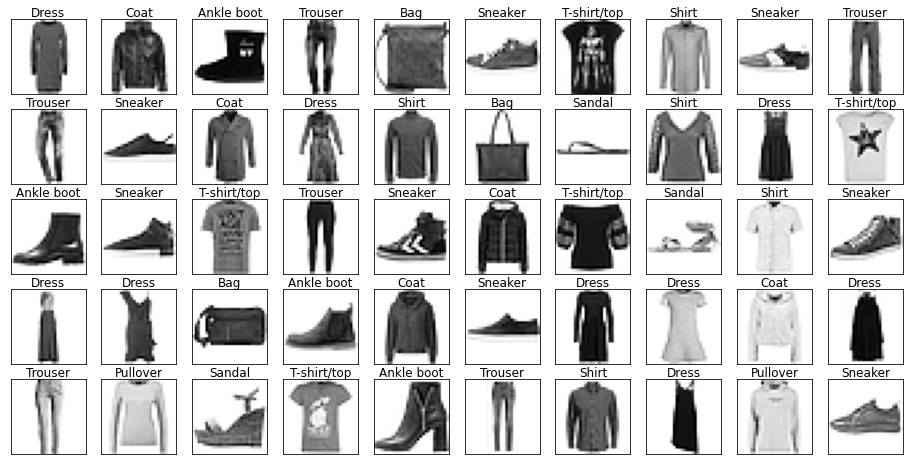

In [20]:
def show_images(data, labels=None, nrows=5, ncols=10, figsize=(16,8), indices=None):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    if indices is None:
        indices=np.random.choice(len(data), size=nrows*ncols, replace=False)
    
    for i, ax in enumerate(axs.ravel()):
        idx = indices[i]
        im = ax.imshow(data[idx], cmap="Greys", norm=matplotlib.colors.Normalize(0., 1.))
        
        if labels is not None:
            ax.set_title(labels[idx], pad=0.0)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return fig, axs

    
fig, ax = show_images(images, labels)

Looking through the categories we can see things like:

* Images are mostly centred, aligned, and cropped
* Trousers are distinctive from their shape
* Shirts are particularly hard to distinguish from tshirt, jacket, pullover and dresshttps://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

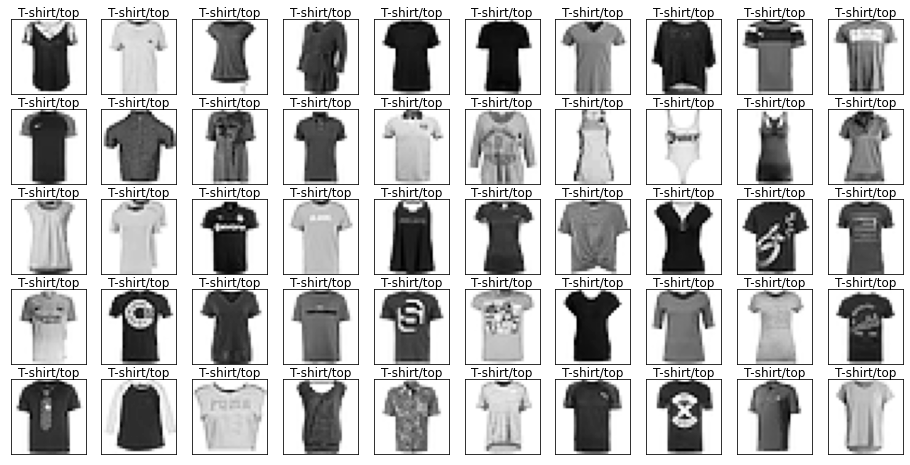

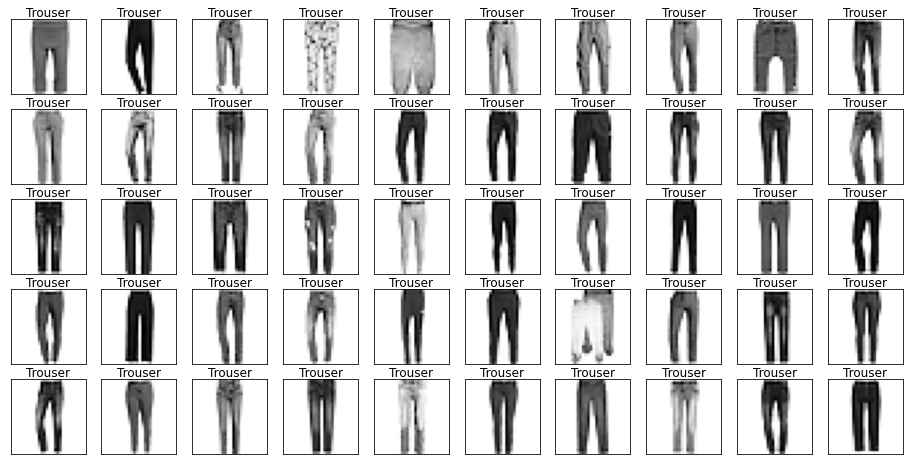

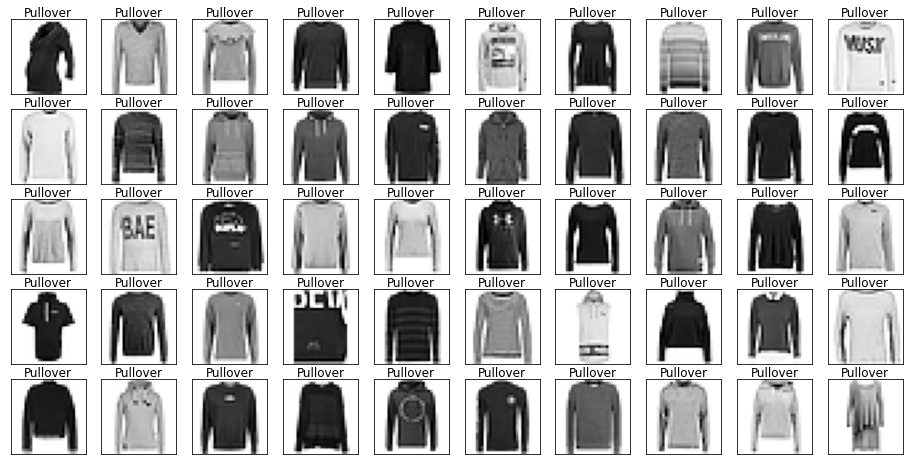

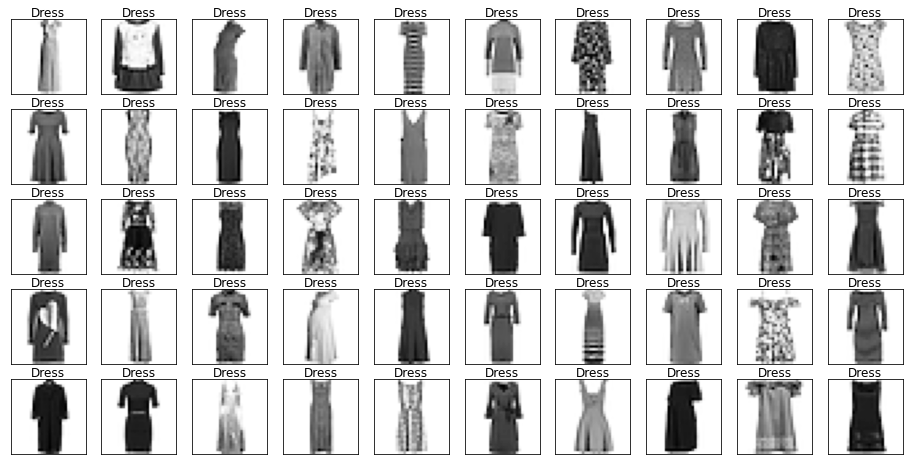

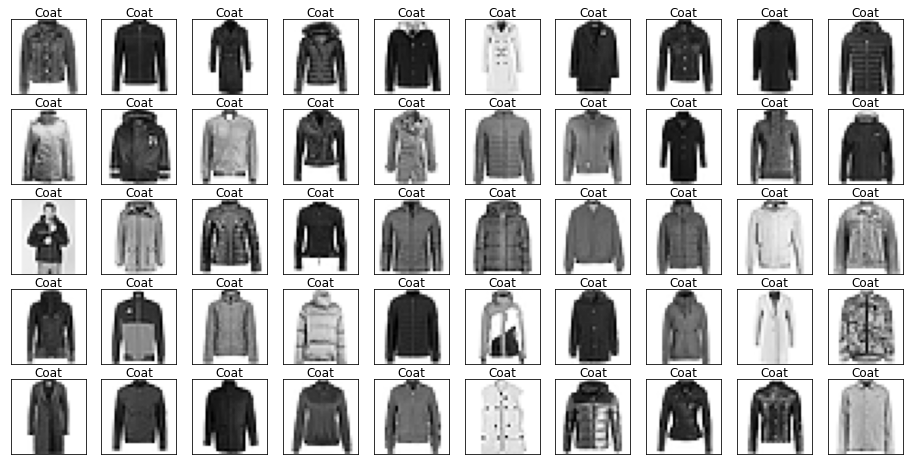

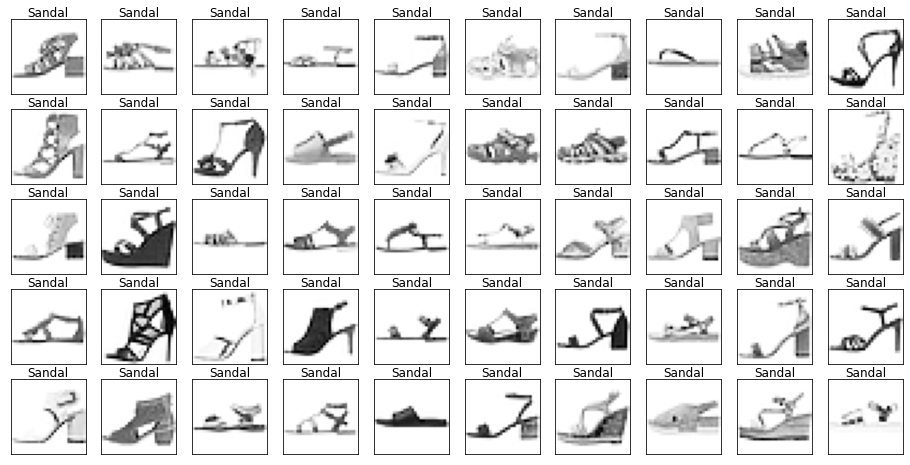

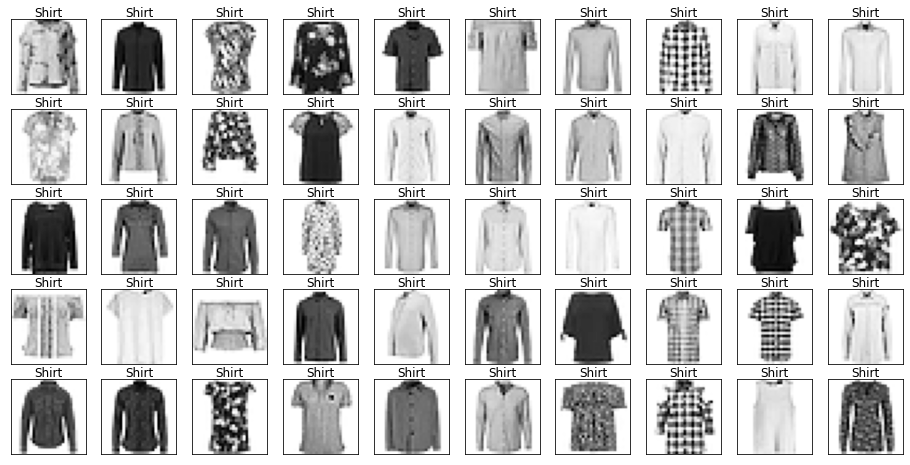

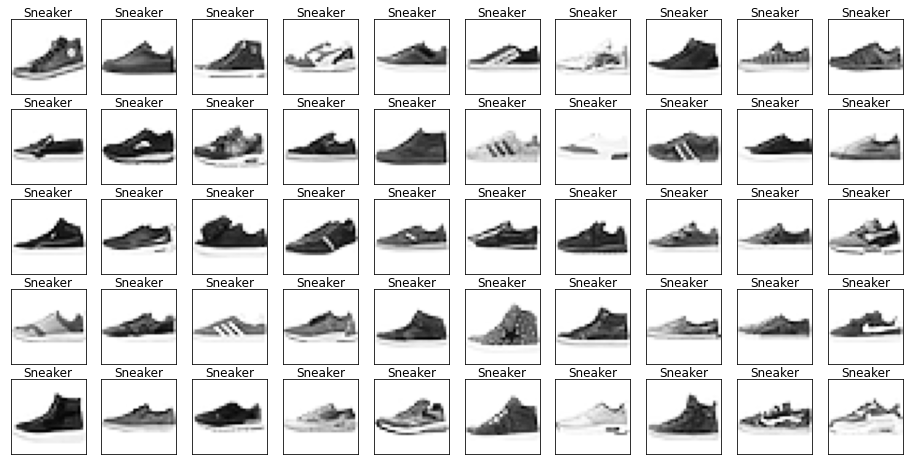

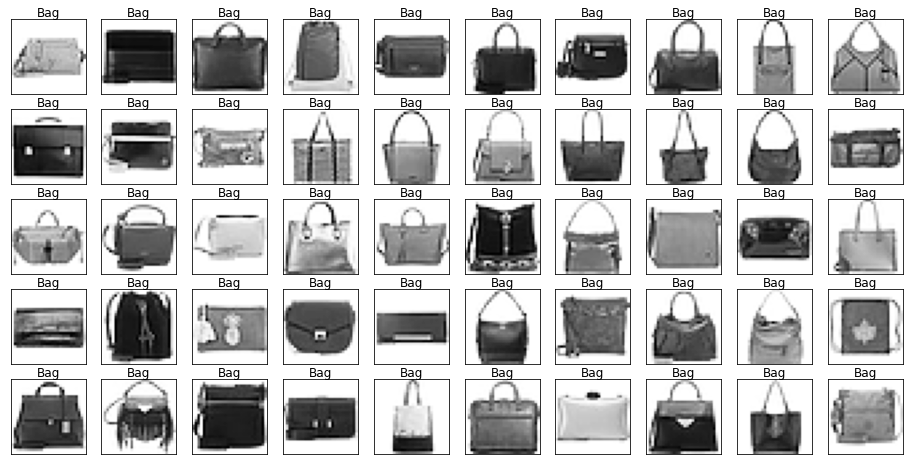

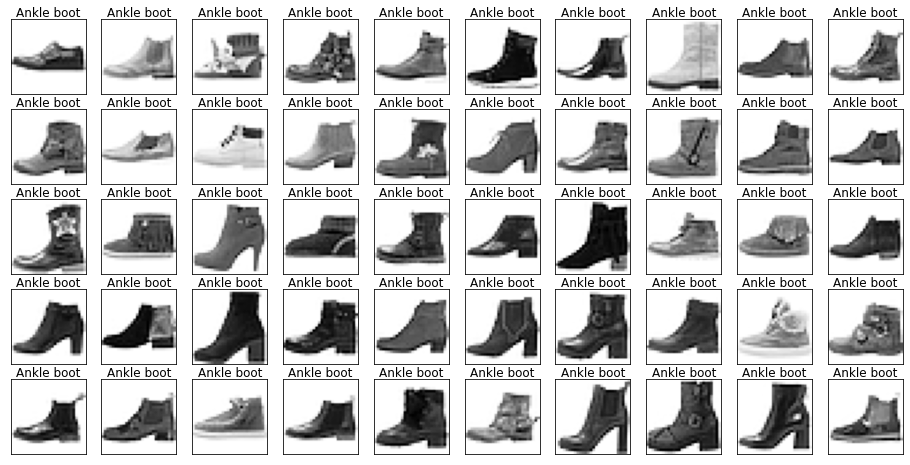

In [21]:
for label in labels.cat.categories:
    mask = labels == label
    show_images(images[mask], labels[mask].reset_index(drop=True))

Let's also have a look at the test data to make sure it's from the same distribution.

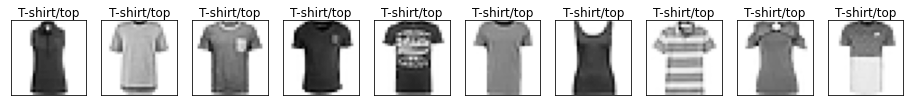

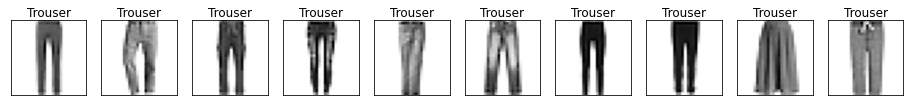

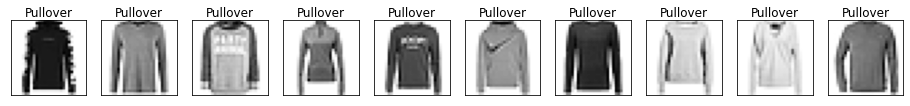

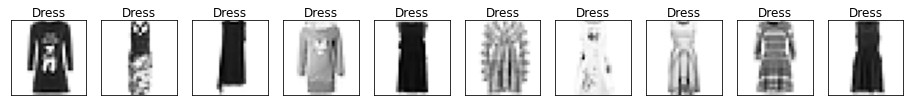

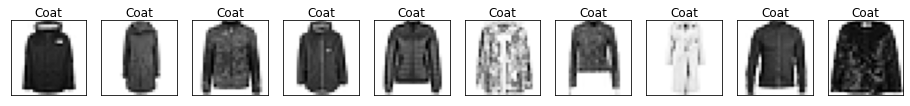

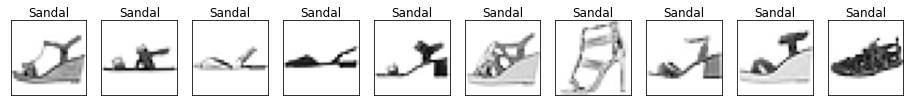

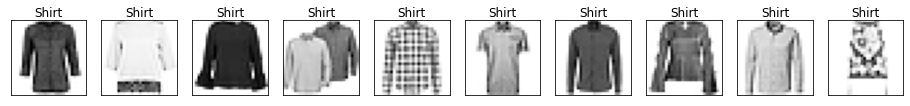

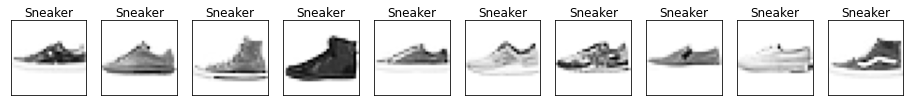

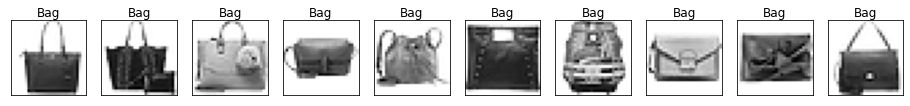

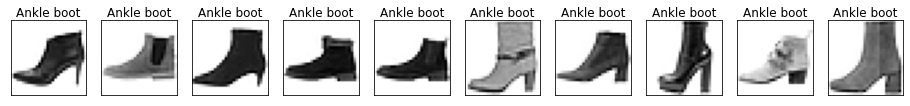

In [22]:
for label in labels_test.cat.categories:
    mask = labels_test == label
    show_images(images_test[mask], labels_test[mask].reset_index(drop=True), nrows=1, ncols=10, figsize=(16,2))

## Duplicate detection

Surprisingly often many duplicates can end up in the training data, or worse leak between the training and test data.
It's always worth doing a check for duplicates.

There a small amount of duplicated in the training set.
We could drop them but they're not too concerning here.

In [23]:
n_train_dup = df.filter(regex='pixel').duplicated().sum()
n_train_dup

43

There's one duplicate in the test set

In [24]:
n_test_dup = df_test.filter(regex='pixel').duplicated().sum()
n_test_dup

1

We also see there are 10 images in the test set from the training set.
This amount of leakage is quite small so we won't worry about it.

In [25]:
pd.concat([df, df_test], axis=0, ignore_index=True).filter(regex='pixel').duplicated().sum() - (n_train_dup + n_test_dup)

10

If we were being more careful we would also look into near duplicates; there may be images that are practically identical but have slightly different pixel representations.

# Creating validation set

It's essential to have a separate validation set to check any of our models on, and tune any hyperparameters. We don't want to overfit to the test set, and will save it for our best model.

Let's make a random 20% sample

In [26]:
valid_pct = 0.2

valid_idx = np.random.choice(len(df), size=int(len(df) * valid_pct), replace=False)

df['valid'] = False
df.loc[valid_idx, 'valid']= True

In [27]:
labels_train, labels_valid = labels[~df['valid']].reset_index(drop=True), labels[df['valid']].reset_index(drop=True)
images_train, images_valid = images[~df['valid']], images[df['valid']]

Let's check the categories are split evently between training and validation sets.

In [28]:
labels_train.value_counts()

Pullover       4876
Ankle boot     4838
Sneaker        4817
Bag            4804
Trouser        4800
Sandal         4790
Shirt          4785
Coat           4773
T-shirt/top    4765
Dress          4752
Name: label, dtype: int64

In [29]:
labels_valid.value_counts()

Dress          1248
T-shirt/top    1235
Coat           1227
Shirt          1215
Sandal         1210
Trouser        1200
Bag            1196
Sneaker        1183
Ankle boot     1162
Pullover       1124
Name: label, dtype: int64

And the data is of the right shape.

In [30]:
images_train.shape, images_valid.shape

((48000, 28, 28), (12000, 28, 28))

# Average Prototype

A simple prototype is to take the pixel average of each category.

In [31]:
prototypes = []
cats = labels_train.cat.categories

for label in cats:
    mask = labels_train == label
    prototypes.append(images_train[mask].mean(axis=(0)))

In [32]:
np.stack(prototypes).shape

(10, 28, 28)

.We can view our "average" prototypes.

Note in particular Sandal is very blurry and hard to distinguish from sneaker.

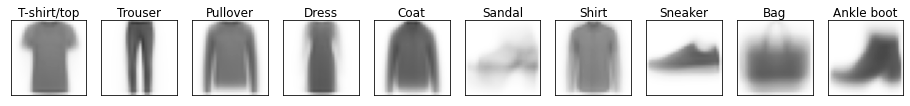

In [33]:
_ = show_images(prototypes, labels=cats, nrows=1, ncols=10, figsize=(16,2), indices=range(10))

We can calculate the distance of the images to these prototypes and classify using the closest prototype.

In [34]:
def mse(a, b):
    return ((a-b) ** 2).mean(axis=(-1,-2))

In [35]:
mse(images_valid[0], prototypes[0])

0.08952501294287363

We can then calculate the distance to each prototype across the dataset.

In [36]:
dists = np.stack([mse(images_valid, ptype) for ptype in prototypes])
dists[0,0], dists.shape

(0.08952501294287363, (10, 12000))

We then predict the class as the closest prototype.

In [37]:
def predict_prototype(images):
    dists = np.stack([mse(images, ptype) for ptype in prototypes])
    pred_idxs = dists.argmin(axis=0)
    # https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes
    return cats[pred_idxs], dists[pred_idxs, np.arange(dists.shape[1])]

We get around 68% on the validation set. Much better than random ~10%, but nowhere near the best models around 90%.

In [38]:
preds_valid, dists_valid = predict_prototype(images_valid)

(preds_valid == labels_valid).mean()

0.6828333333333333

We get a similar score on the trianing set; there are very few parameters in this model (7840 for the pixels of the prototypes), and it won't overfit.

In [39]:
preds, dists = predict_prototype(images_train)

(preds == labels_train).mean()

0.6847291666666667

### Confusion matrix

To understand how to improve the model it's useful to use the Confusion Matrix, showing which classes are being mixed up by the model. We could use [sklear ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay) but it's straightforward to create ourselves.

As expected trouser is the easiest and shirt is the hardest.

Interestingly sandal is the most predicted category and different kinds of items are predicted for it.

In [40]:
from collections import Counter

def plot_confusion_matrix(y_true, y_pred, figsize=(10,10), labels=cats):
    counts = Counter(zip(y_true, y_pred))
    
    confusion_matrix = np.array([[counts[true_cat, pred_cat] for pred_cat in cats] for true_cat in cats])
    
    maxval = confusion_matrix.max()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_xticks(np.arange(len(labels)), labels=[f'{label}\n({total})' for label, total in zip(labels, confusion_matrix.sum(axis=0))])
    ax.set_yticks(np.arange(len(labels)), labels=[f'{label}\n({total})' for label, total in zip(labels, confusion_matrix.sum(axis=1))])
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    im = ax.imshow(confusion_matrix, cmap="magma")
    
    for i in range(len(cats)):
        for j in range(len(cats)):
            datum = confusion_matrix[i, j]
            text = ax.text(j, i, datum, ha="center", va="center", color='black' if datum > maxval/2 else 'white')
    return ax    

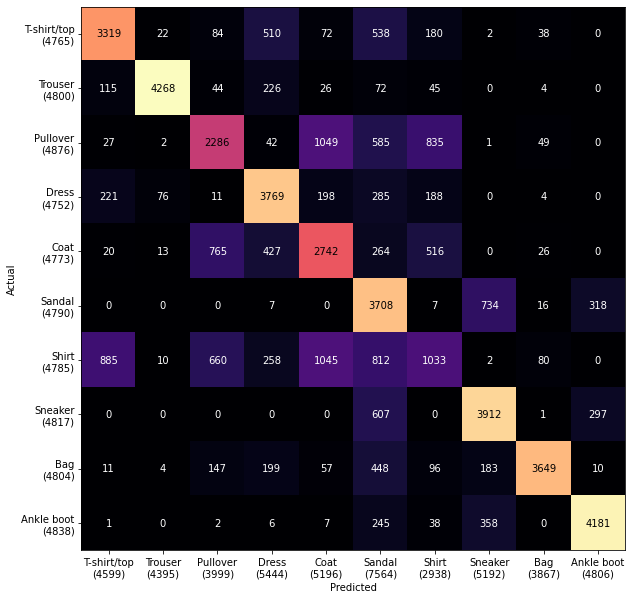

In [41]:
_ = plot_confusion_matrix(labels_train, preds)

The validation set shows a very similar pattern

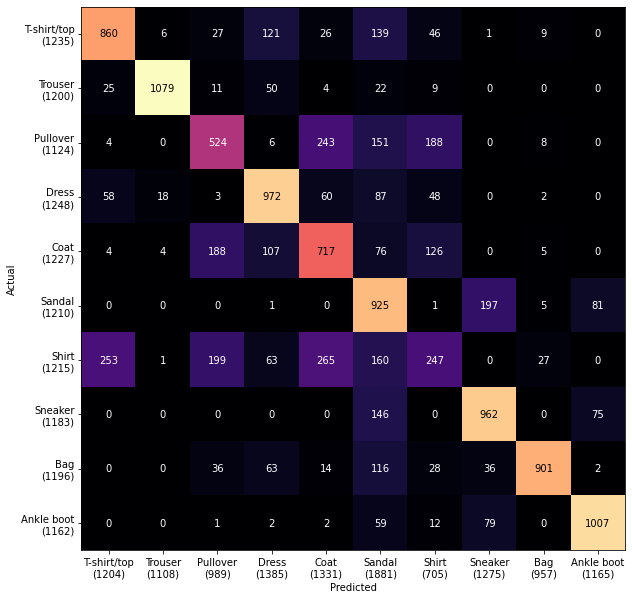

In [42]:
_ = plot_confusion_matrix(labels_valid, preds_valid)

### Error analysis

Remember these are our prototypes

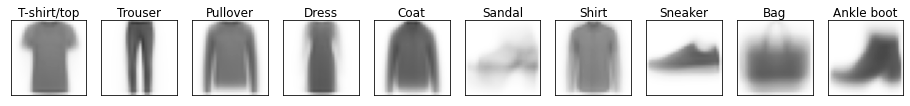

In [43]:
_ = show_images(prototypes, labels=cats, nrows=1, ncols=10, figsize=(16,2), indices=range(10))

Let's look at the predictions that are furthest from the prototypes.

Becuase the prototypes are an average grey these are the furthest away.

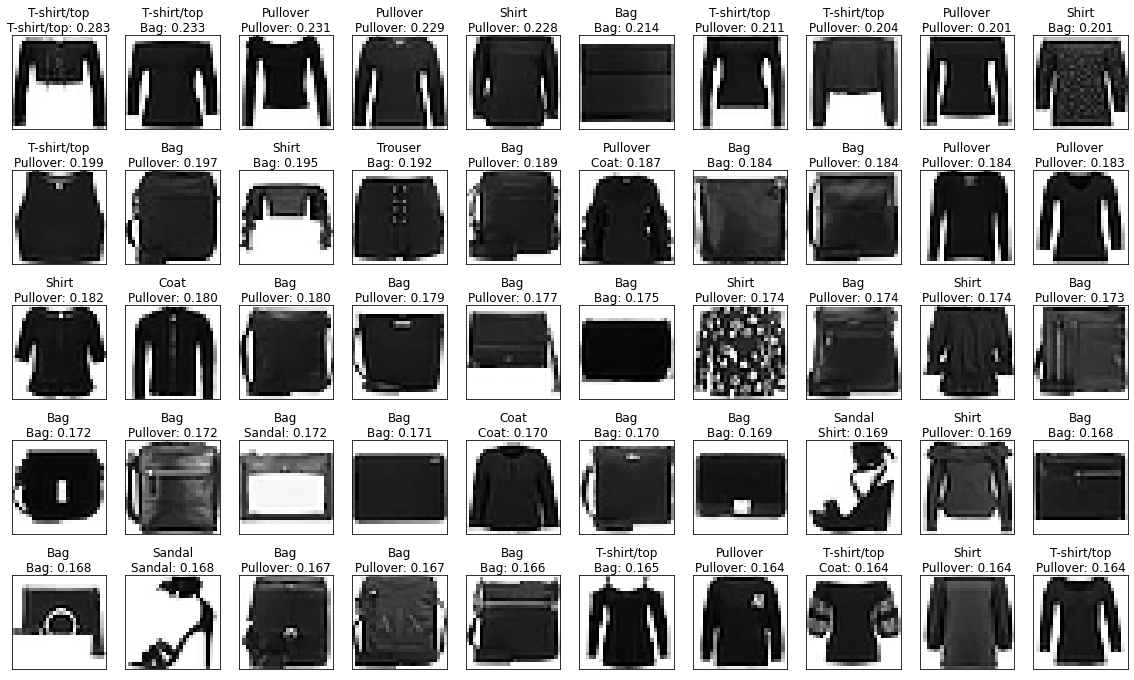

In [44]:
def pred_text(labels, dists, preds):
    return [f'{label}\n{pred}: {dist:0.3f}' for label, dist, pred in zip(labels, dists, preds)]

fig, axs = show_images(images_train, pred_text(labels_train, dists, preds),
                       indices=np.argsort(-dists), 
                       figsize=(20,12))

Another angle to look at is the ones that are very close to a wrong category.

* It's often mistaking sneakers for sandals
* Many of the shirts/t-shirts/coat/pullover examples are quite hard!

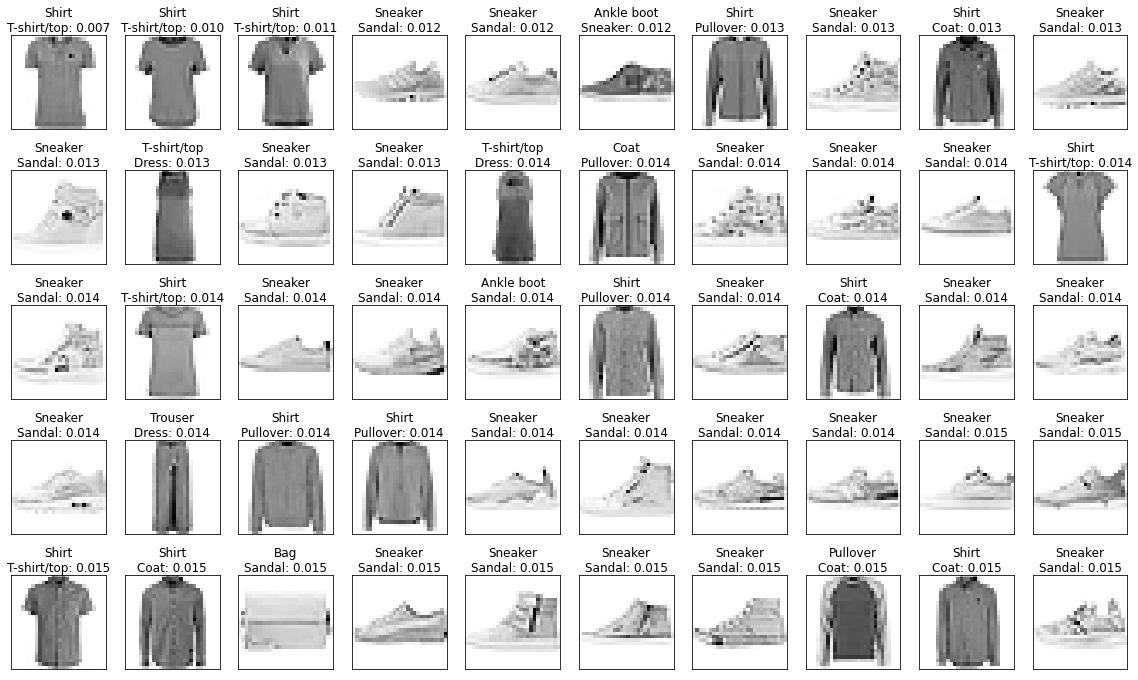

In [45]:
indices_confident_wrong = np.argsort(np.where(labels_train != preds, dists, np.inf))

fig, axs = show_images(images_train, pred_text(labels_train, dists, preds), indices=indices_confident_wrong, figsize=(20,12))

# Multiple prototypes - K Means Clustering

Sandals didn't do well because there are multiple kinds of sandals; we need more than 1 prototype. We could find different prototypes with K-Means Clustering.

In [46]:
k = 3

We'll initialize on random images

In [47]:
images_sandal = images_train[labels_train == 'Sandal']

In [48]:
points = images_sandal[np.random.choice(len(images_sandal), k)]

We can look at our initial examples

(<Figure size 1152x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

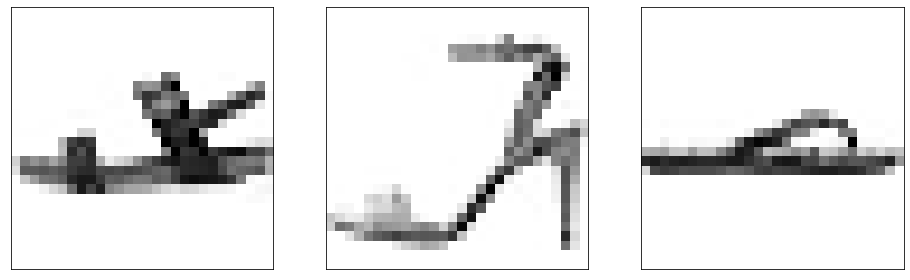

In [49]:
show_images(points, nrows=1, ncols=k, indices=range(k))

The K means algorithm updates the prototypes by replacing them with the centre of their nearest points

In [50]:
dists = np.stack([mse(images_sandal, ptype) for ptype in points])
pred_idx = dists.argmin(axis=0)

Mean distance to closest point

In [51]:
dists[pred_idx, np.arange(len(pred_idx))].mean()

0.07609486260835334

In [52]:
new_points = [np.zeros_like(p) for p in points]
counts = Counter(pred_idx)
for p, img in zip(pred_idx, images_sandal):
    new_points[p] += img / counts[p]

The points have moved somewhat

In [53]:
((points - new_points) ** 2).max()

0.5780382666820493

The points are closer to the centres

In [54]:
dists = np.stack([mse(images_sandal, ptype) for ptype in new_points])
pred_idx = dists.argmin(axis=0)
dists[pred_idx, np.arange(len(pred_idx))].mean()

0.041198112905058926

The points look less distinct.

(<Figure size 1152x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

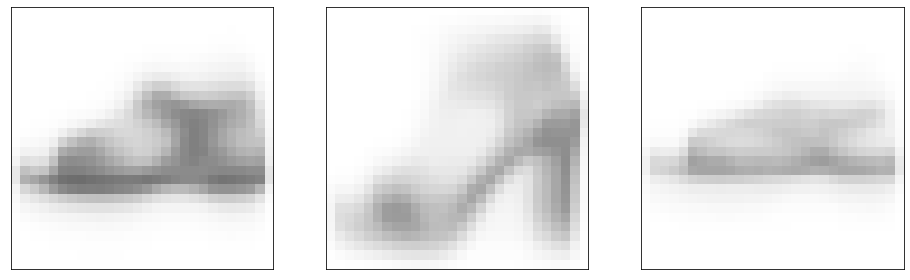

In [55]:
show_images(new_points, nrows=1, ncols=k, indices=range(k))

In [56]:
def kmeans_update(points, images):
    dists = np.stack([mse(images_sandal, ptype) for ptype in points])
    pred_idx = dists.argmin(axis=0)
    
    avg_closest_dist = dists[pred_idx, np.arange(len(pred_idx))].mean()
    
    new_points = [np.zeros_like(p) for p in points]
    counts = Counter(pred_idx)
    for p, img in zip(pred_idx, images_sandal):
        new_points[p] += img / counts[p]
        
    return np.stack(new_points), avg_closest_dist

In [57]:
new_points, dist = kmeans_update(points, images_sandal)

dist, ((new_points - points)**2).mean()

(0.07609486260835334, 0.03428306668446661)

In [58]:
for _ in range(20):
    new_points, dist = kmeans_update(points, images_sandal)
    print(dist, ((new_points - points)**2).mean())
    points = new_points

0.07609486260835334 0.03428306668446661
0.041198112905058926 0.00023726827891309429
0.04092454159135468 1.3108373812449763e-05
0.04090896432848311 1.7028060653073558e-06
0.04090644168969744 1.019623124431402e-06
0.04090493622002984 7.511999849344715e-07
0.04090387345615791 2.3532142621230394e-07
0.04090353329883353 1.159359378424659e-07
0.04090339045888112 5.988210697082061e-08
0.040903300380743315 5.099355708565635e-08
0.0409032466943707 9.259498571269447e-09
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0
0.04090323766449002 0.0


We get a few different kinds of sandal protoype. But they still don't look very good.

(<Figure size 1152x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

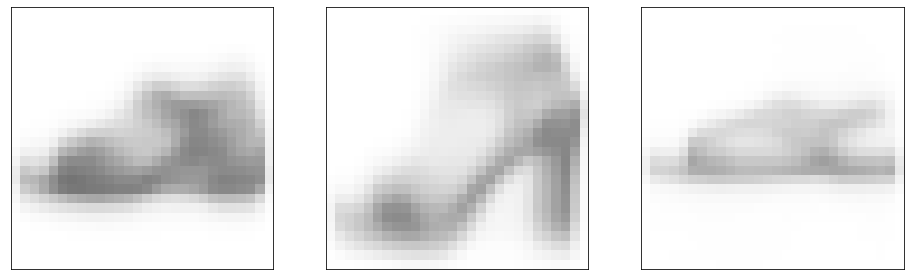

In [59]:
show_images(points, nrows=1, ncols=k, indices=range(k))

Lets add these to the prototypes

In [60]:


sandal_idx = list(cats).index('Sandal')

new_prototype_cats = np.array(list(cats)[:sandal_idx] + list(cats)[sandal_idx+1:] + k*['Sandal'])

new_prototypes = prototypes[:sandal_idx] + prototypes[sandal_idx+1:] + list(points)

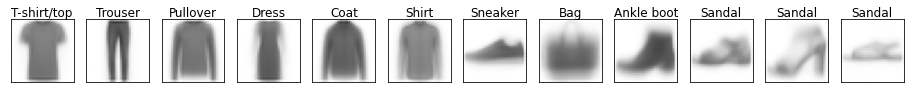

In [61]:
_ = show_images(new_prototypes, new_prototype_cats, nrows=1, ncols=len(new_prototypes), indices=range(len(new_prototypes)))

In [62]:
def predict_prototype(images, prototypes, cats):
    dists = np.stack([mse(images, ptype) for ptype in prototypes])
    pred_idxs = dists.argmin(axis=0)
    return cats[pred_idxs], dists[pred_idxs, np.arange(dists.shape[1])]

In [63]:
preds, dists = predict_prototype(images_valid, new_prototypes, new_prototype_cats)

It doesn't change the accuracy much

In [64]:
(preds == labels_valid).mean()

0.6850833333333334

There are potential ways we could produce better prototypes, like Learning Vector Quantization that tries to avoid images close to the boundaries.
But another approach is to use the images themselves as prototypes using K-nearest neighbours.

# K-nearest neighbours

This approach finds the closest images to the training data and assigns the most common category.
Here's a method to do that.

Let's tart with a validation image

Shirt


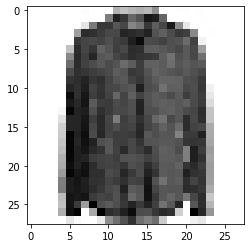

In [65]:
print(labels_valid[0])
plt.imshow(images_valid[0], cmap='Greys')

We then compute the distance to each training image

In [66]:
dists =  ((images_valid[0] - images_train) ** 2).mean(axis=(-1,-2))
dists

array([0.13868883, 0.24805587, 0.13288863, ..., 0.21719462, 0.11814736,
       0.16748133])

Then we find the closest k points.

We use `argpartition` for a fast sort of the first k entries

In [67]:
k= 3
top_idx = np.argpartition(dists, k)[:k]

We can check these are the the closest

In [68]:
dists[top_idx]

array([0.01323082, 0.01435262, 0.01550489])

In [69]:
for idx in top_idx:
    assert (dists[idx] >= dists).sum() <= k

We can inspect them and see that they are pixelwise similar

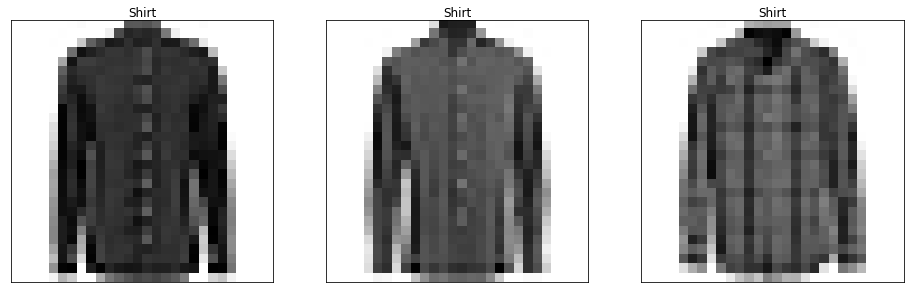

In [70]:
_ = show_images(images_train, labels_train, nrows=1, ncols=k, indices=top_idx)

We can then get the corresponding labels and their counts

In [71]:
pred_labels = labels_train.loc[top_idx]
pred_labels

28647    Shirt
42701    Shirt
28258    Shirt
Name: label, dtype: category
Categories (10, object): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', ..., 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [72]:
pred_counts = Counter(pred_labels)
pred_counts

Counter({'Shirt': 3})

We can get the most common label and its count.

In [73]:
pred_label, label_count = pred_counts.most_common(n=1)[0]
pred_label, label_count

('Shirt', 3)

Let's wrap all this up in a class

In [74]:
class KNN():
    def __init__(self, images, labels, k=1):
        self.images = images
        self.labels = labels
        self.k = k
        
    def __call__(self, image, k=None):
        k = k or self.k
        
        dists = ((image - self.images) ** 2).mean(axis=(-1,-2))
        top_idx = np.argpartition(dists, k) [:k]
    
        pred_labels = self.labels.loc[top_idx]
        pred_counts = Counter(pred_labels)
        pred_label, label_count = pred_counts.most_common(n=1)[0]
    
        return pred_label 

In [75]:
knn = KNN(images_train, labels_train)

In [76]:
knn(images_valid[0]), labels_valid[0]

('Shirt', 'Shirt')

We can then iterate over the validation images; unfortunately it's quite slow!

In [77]:
%time preds = [knn(i) for i in images_valid[:100]]

CPU times: user 12.4 s, sys: 7.16 s, total: 19.5 s
Wall time: 19.5 s


In [78]:
len(images_train)

48000

We can speed it up by only using a random sample of the training images.

In [79]:
sample = np.random.choice(len(images_train), 1_000, replace=False)

knn_small = KNN(images_train[sample], labels_train.loc[sample].reset_index(drop=True))

In [80]:
%time preds = [knn_small(i) for i in images_valid]

CPU times: user 28.3 s, sys: 65.2 ms, total: 28.4 s
Wall time: 28.4 s


This does considerably better than the other methods

In [81]:
np.mean(preds == labels_valid)

0.7454166666666666

Increasing k slighly changes the result

In [82]:
%time preds = [knn_small(i, k=5) for i in images_valid]

CPU times: user 28 s, sys: 97.7 ms, total: 28.1 s
Wall time: 28.1 s


In [83]:
np.mean(preds == labels_valid)

0.7546666666666667

How does it scale with the number of training images used?

Let's make a function to evaluate a sample on the validation set and return the result.

In [84]:
def eval_knn_sample(n, k):
    sample = np.random.choice(len(images_train), n, replace=False)
    knn = KNN(images_train[sample], labels_train.loc[sample].reset_index(drop=True), k=k)
    
    preds = [knn(i) for i in images_valid]
    return np.mean(preds == labels_valid)

Let's also track how long it takes for each size.

In [85]:
import time

def with_time(f, *args, **kwargs):
    start_time = time.monotonic_ns()
    result = f(*args, **kwargs)
    elapsed_time = time.monotonic_ns() - start_time
    return result, elapsed_time / 1e9

Now we'll try a few, small, increasing sizes capture the accuracy and speed (I've just set k=1 here to keep it faster; you could use different values of k).

In [86]:
%%time

knn_evals = []
for k in [1]:
    for n in [200, 400, 800, 1600]:
        acc, elapsed_time = with_time(eval_knn_sample, n, k)
        knn_evals.append(dict(k=k, n=n, acc=acc, time=elapsed_time))

CPU times: user 1min 31s, sys: 210 ms, total: 1min 32s
Wall time: 1min 32s


We can then plot how the error rate scales with size.

<AxesSubplot:xlabel='n', ylabel='err'>

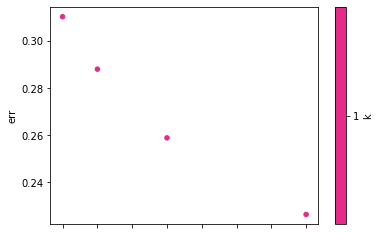

In [87]:
df_knn_evals = pd.DataFrame(knn_evals).assign(err=lambda _: 1 - _.acc)

df_knn_evals.assign(k=lambda _: pd.Categorical(_.k)).plot.scatter(x='n', y='err', c='k', cmap='Dark2')

On log-log axes it's a straight line

<AxesSubplot:xlabel='n', ylabel='err'>

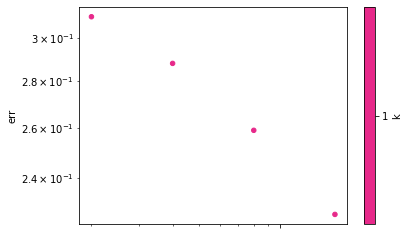

In [88]:
df_knn_evals.assign(k=lambda _: pd.Categorical(_.k)).plot.scatter(x='n', y='err', c='k', cmap='Dark2', logx=True, logy=True)

Let's fit a linear model in log-log space to get an idea of how this will scale.
We have to be careful about extrapolating and any estimate of accuracy we make is likely to be optimistic.

In [89]:
log_err_1 = np.log2(df_knn_evals.query('k==1')['err'].to_numpy())
log_err_1

array([-1.68810943, -1.7954419 , -1.94944026, -2.14294794])

Get around 0.15 increase in log2 accuracy for each doubling of data.

This is the slope of our line

In [90]:
log_err_1[:-1] - log_err_1[1:]

array([0.10733247, 0.15399836, 0.19350768])

In [91]:
slope = np.mean(log_err_1[:-1] - log_err_1[1:])
slope

0.15161283577893947

We then find the intercept to match the average actual error.

In [92]:
c = df_knn_evals.assign(resid = lambda _: np.log2(_.err) + slope*np.log2(_.n)).resid.mean()
c

-0.5076589129554365

The predictions can be wrapped in a function

In [93]:
def pred_error(n):
    log2_pred = c - slope * np.log2(n)
    return 2**log2_pred

And the fit looks pretty good

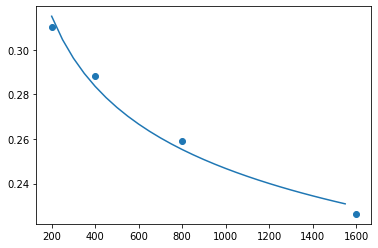

In [94]:
x = np.arange(df_knn_evals.n.min(), df_knn_evals.n.max(), step=50)
plt.plot(x, pred_error(x))
plt.scatter(df_knn_evals.n, df_knn_evals.err)

We have to be careful when extrapolating, but error could get down to about 14%.
This is likely to be slightly optimistic so maybe 15-16% is a better guess.

In [95]:
pred_error(len(images_train))

0.13722814118447552

On the other hand time is linear

<AxesSubplot:xlabel='n'>

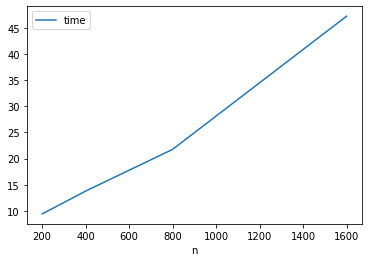

In [96]:
df_knn_evals.plot('n', 'time')

It would take a while to run over all the samples.

In [97]:
import datetime

len(images_train) / df_knn_evals.n.max() * df_knn_evals.time.max() / 60 # seconds/minute

23.600099697

## Making it faster with Approximate Nearest Neighbours

Instead of brute force searching for the closest point we can use [Approximate Nearest Neighbours](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Approximate_nearest_neighbor) to speed it up.
There are many good libraries including faiss and hnswlib, but we'll use [annoy](https://github.com/spotify/annoy).

It uses [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing); see Chapter 3 of [Mining of Massive Datasets, by Leskovec, Rajaraman and Ullman](http://www.mmds.org/) for a good overview.

In [98]:
from annoy import AnnoyIndex

First we initialise an index and add all the vectors

In [99]:
%%time
t = AnnoyIndex(28*28, 'euclidean')
for i, v in enumerate(images_train):
    t.add_item(i, v.flatten())

CPU times: user 7.88 s, sys: 229 ms, total: 8.11 s
Wall time: 7.9 s


Then we build the index, specifying the number of trees. 10 seems to work fine in this case.

In [100]:
t.build(10)

True

We then adapt our search to use the nearest neighbour from the index rather than brute forcing the search.

In [101]:
def ann_pred(v, k=1, search_k=-1):
    n = t.get_nns_by_vector(v.flatten(), k, search_k=search_k, include_distances=False)
    pred_labels = labels_train.loc[n]
    pred_counts = Counter(pred_labels)
    pred_label = pred_counts.most_common(n=1)[0][0]
    
    return pred_label

We can then get results in seconds rather than minutes.

In [102]:
%time preds = [ann_pred(i, k=5) for i in images_valid]

CPU times: user 13.7 s, sys: 7.48 ms, total: 13.7 s
Wall time: 13.7 s


And we get around 85% accuracy, matching the ~15% error rate we expected from an exact solution

In [103]:
np.mean(preds == labels_valid)

0.84875

We're getting much more even predictions and more understandable confusion between:

* top/pullover/coat/shirt
* ankle boot/sneaker/sandal

The worst performing is shirt, which was the hardest for me to identify

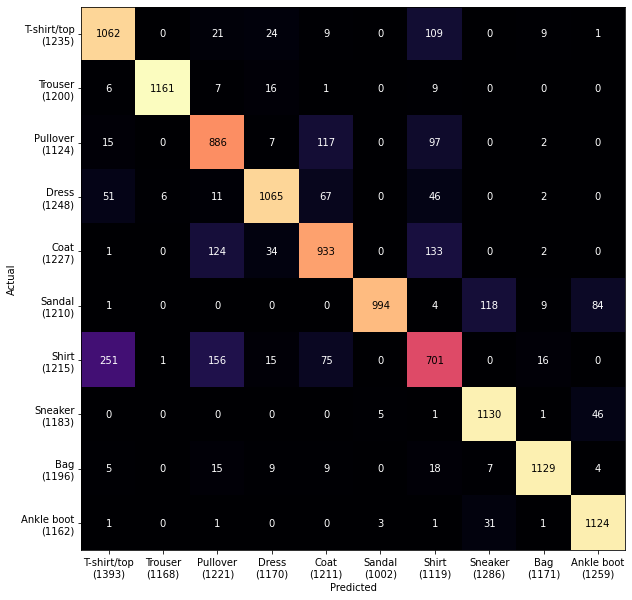

In [104]:
_ = plot_confusion_matrix(labels_valid, preds)

Let's grab an example where we the label was Shirt and we predicted T-shirt/top.

It looks like a t-shirt to me

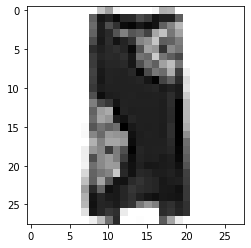

In [105]:
img = images_valid[(np.array(preds) == 'T-shirt/top') & (labels_valid == 'Shirt')][0]
plt.imshow(img, cmap='Greys')

And we can see the nearby items that led to the prediction.

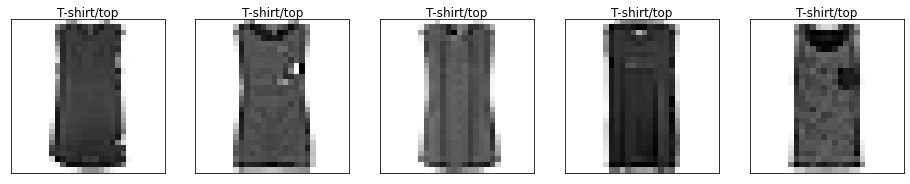

In [106]:
k = 5

n = t.get_nns_by_vector(img.flatten(), k)

_ = show_images(images_train, labels_train, nrows=1, ncols=k, indices=n)

Another example is a pair of trousers the model guessed was a dress

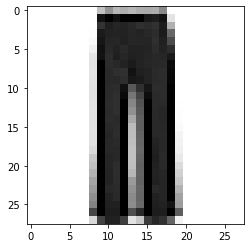

In [107]:
img = images_valid[(np.array(preds) == 'Dress') & (labels_valid == 'Trouser')][0]
plt.imshow(img, cmap='Greys')

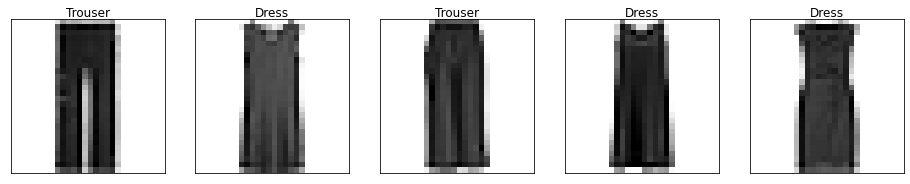

In [108]:
n = t.get_nns_by_vector(img.flatten(), k)
_ = show_images(images_train, labels_train, nrows=1, ncols=k, indices=n)

There's no obvious way to improve the model, so let's do a hyperparameter search for the best k

In [109]:
%%time

accs = {}
for k in [1,5,10,20,100]:
    preds = [ann_pred(i, k=k) for i in images_valid]
    accs[k] = np.mean(preds == labels_valid)

CPU times: user 1min 8s, sys: 10 ms, total: 1min 8s
Wall time: 1min 8s


It looks like 5 is marginally better

In [110]:
pd.Series(accs).sort_values(ascending=False).to_frame()

,0
5,0.848750
10,0.841750
1,0.841083
20,0.832833
100,0.806250


Now we have our best prototype model lets evaluate on the test set, and we get an accuracy of around 85%.
Comparing with the [benchmarks](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#) using sklearn this is about what they get with KNN methods (and it looks like using Manhattan Distance, aka l^p with p=1, would do slightly better).

Given the very best methods get around 90% (or up to 94% with convolutional neural networks) this is quite good!

In [111]:
%%time
preds = [ann_pred(i, k=5) for i in images_test]
np.mean(preds == labels_test)

CPU times: user 10.5 s, sys: 502 µs, total: 10.5 s
Wall time: 10.5 s


0.849

Of course we could have done this all in a few lines of sklearn. But by looking through understanding how it works and looking at the images we get a much better idea of why we get these results, and maybe ideas on how to improve it. (I expect the sklearn method below does better by standardizing the features before computing distances; that would be an interesting exercise.)

In [112]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()
knn.fit(df.filter(like='pixel', axis=1), df['label'])

preds = knn.predict(df_test.filter(like='pixel', axis=1))
accuracy_score(df_test['label'], preds)

CPU times: user 1min 9s, sys: 8.63 s, total: 1min 18s
Wall time: 30.9 s


0.8589

Prototype methods are remarkably simple, quick to train and flexible.
Because the images here are so simple we get good results on the pixels directly.
For more complex datatypes we could use derived features; in particular the activations from a pretrained neural network such as Resnet, BERT, or CLIP can work well.

For more on prototype methods read Chapter 13 of [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/).